In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd 
import imp
import glob
import os
import numpy as np
from collections import defaultdict
from sqlalchemy import create_engine
sn.set_context('notebook')

# ICPW annual time series

At the Task Force meeting in May 2017, it was decided that the TOC trends analysis should include rolling regressions based on the annually aggregated data (rather than calculating a single set of statistics for a small number of pre-specified time periods). Some code outlining an approach for this in Python can be found here [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/rolling_sens_slope.ipynb), and John has also created a version using R.

Heleen has asked me to provided John with annual time series for each site for the period from 1990 to 2012 (see e-mail received from Heleen on 12/05/2017 at 10.01 and also the e-mail chain involving John, Don and Heleen between 19th and 20th May 2017).

As a first step, I've modified my previous trends code so that, duirng the processing, the annual time series are saved as a series of CSVs. The additional lines of code can be found on lines 567 to 574 of [toc_trend_analysis.py](https://github.com/JamesSample/icpw/blob/master/toc_trends_analysis.py).

The output CSVs require a small amount of manual cleaning:

 * Delete the TOC series for station ID 23467 and <br><br>
 
 * Delete the SO4 series for station ID 36561.
 
(See sections 1.2 and 1.3 of [this notebook](https://github.com/JamesSample/icpw/blob/master/toc_trends_oct_2016_part3.ipynb) for justification).

Annual time series for climate based on the updated climate data have already been created and are saved here:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\CRU_Climate_Data\cru_climate_summaries.xlsx

The temperature series also need correcting based on site elevation, as was done in [this notebook](https://github.com/JamesSample/icpw/blob/master/icpw_climate_trends.ipynb) and the two (climate and water chemistry) datasets then need restructuring and joining into a single output file for John to work with.

In [2]:
# Data paths
clim_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
            r'\CRU_Climate_Data\cru_climate_summaries.xlsx')

stn_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\cru_stn_elevs.csv')

chem_fold = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
             r'\Results\annual_chemistry_series')

In [3]:
# For performance, pre-load the climate output file
# (this saves having to read it within the inner loop below,
# which is very slow)
clim_dict = {}
for var in ['pre', 'tmp']:
    for tm in ['ann', 'jja', 'jas']:
        # Open the climate data
        clim_df = pd.read_excel(clim_xls, sheetname='%s_%s' % (var, tm))
        clim_dict[(var, tm)] = clim_df

In [4]:
# Read stn elev data
stn_df = pd.read_csv(stn_xls)

# Get list of sites
stn_list = stn_df['stn_id'].unique()
               
# List to store output
data_list = []

# Loop over stations
for stn in stn_list:
    # Read chem data
    chem_path = os.path.join(chem_fold, 'stn_%s.csv' % stn)
    
    # Only process the 431 files with chem data
    if os.path.exists(chem_path):
        # Allow for manually edited stations (see above)
        # which now have ';' as the delimiter
        if stn in [23467, 36561]:
            chem_df = pd.read_csv(chem_path, sep=';')
        else:
            chem_df = pd.read_csv(chem_path)
        chem_df.index = chem_df['YEAR']

        # Process climate data
        # Dict to store output
        data_dict = {}

        # Loop over data
        for var in ['pre', 'tmp']:
            for tm in ['ann', 'jja', 'jas']:
                # Get the climate data
                clim_df = clim_dict[(var, tm)]     

                # Filter the climate data for this station
                stn_clim_df = clim_df.query('stn_id == @stn')

                # Set index
                stn_clim_df.index = stn_clim_df['year']
                stn_clim_df = stn_clim_df.sort_index()

                # Correct temperatures according to lapse rate
                if var == 'tmp':
                    # Get elevations
                    stn_elev = stn_df.query('stn_id == @stn')['elev_m'].values[0]
                    px_elev = stn_df.query('stn_id == @stn')['px_elev_m'].values[0]

                    # If pixel elev is negative (i.e. in sea), correct back to s.l.
                    if px_elev < 0:
                        px_elev = 0

                    # Calculate temperature difference based on 0.6C/100m
                    t_diff = 0.6 * (px_elev - stn_elev) / 100.

                    # Apply correction
                    stn_clim_df['tmp'] = stn_clim_df['tmp'] + t_diff

                # Truncate
                stn_clim_df = stn_clim_df.query('(year>=1990) & (year<=2012)')

                # Add to dict
                key = '%s_%s' % (var, tm)
                val = stn_clim_df[var]
                data_dict[key] = val

        # Build output df
        stn_clim_df = pd.DataFrame(data_dict)

        # Join chem and clim data
        df = pd.merge(stn_clim_df, chem_df, how='outer',
                      left_index=True, right_index=True)

        # Get desired columns
        # Modified 06/06/2017 to include all pars for Leah
        df = df[['pre_ann', 'pre_jas', 'pre_jja', 'tmp_ann', 'tmp_jas',
                 'tmp_jja', 'Al', 'TOC', 'EH', 'ESO4', 'ECl', 'ESO4_ECl',
                 'ENO3', 'ESO4X', 'ESO4_ECl', 'ECa_EMg', 'ECaX_EMgX', 
                 'ANC']]

        # Transpose
        df = df.T

        # Add station ID
        df.reset_index(inplace=True)
        df['station_id'] = stn

        # Rename cols
        df.columns.name = ''
        cols = list(df.columns)
        cols[0] = 'var'
        df.columns = cols

        data_list.append(df)

# Combine results for each site
ann_df = pd.concat(data_list, axis=0)

ann_df.head()

,var,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,station_id
0,pre_ann,1401.800000,1405.200000,1162.800000,1394.000000,1475.500000,1338.800000,1365.900000,1158.600000,1471.600000,...,1329.100000,1820.000000,1574.800000,1365.900000,1540.600000,1762.400000,1560.700000,1561.300000,1282.000000,37284
1,pre_jas,359.700000,470.600000,249.400000,189.200000,245.300000,235.500000,337.000000,184.000000,247.300000,...,320.700000,334.500000,321.200000,290.400000,335.600000,420.900000,278.400000,344.800000,396.400000,37284
2,pre_jja,324.600000,359.900000,273.600000,202.300000,236.900000,320.200000,208.500000,183.300000,258.300000,...,295.200000,261.600000,515.400000,270.300000,188.800000,500.000000,315.500000,359.200000,269.400000,37284
3,tmp_ann,8.128333,7.470000,6.086667,6.586667,7.011667,7.161667,6.928333,6.686667,7.903333,...,6.228333,7.278333,8.486667,6.736667,7.470000,7.245000,8.503333,8.120000,8.686667,37284
4,tmp_jas,18.920000,17.753333,16.786667,18.120000,18.353333,17.820000,17.520000,17.953333,17.920000,...,17.520000,18.353333,18.353333,17.986667,18.286667,17.853333,19.020000,18.753333,19.553333,37284


The final step is to join in the site metadata used in the previous analysis. 

In [5]:
# Read site data from previous output
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
          r'\Results\toc_trends_long_format_update1.xlsx')
props_df = pd.read_excel(in_xls, sheetname='toc_trends_long_format_update1', 
                         keep_default_na=False) # Otherwise 'NA' for North America becomes NaN

# Get just cols of interest
props_df = props_df[['project_id', 'project_name', 'station_id', 'station_code', 
                     'station_name', 'nfc_code', 'type', 'continent', 'country', 
                     'region', 'subregion', 'lat', 'lon']]

# Drop duplicates
props_df.drop_duplicates(inplace=True)

# Join
ann_df = pd.merge(ann_df, props_df, how='left',
                  on='station_id')

# Reorder cols
ann_df = ann_df[['project_id', 'project_name', 'station_id', 'station_code', 
                 'station_name', 'nfc_code', 'type', 'continent', 'country', 
                 'region', 'subregion', 'lat', 'lon', 'var']+range(1990, 2013)]

ann_df.head()

,project_id,project_name,station_id,station_code,station_name,nfc_code,type,continent,country,region,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,1405.300000,1329.100000,1820.000000,1574.800000,1365.900000,1540.600000,1762.400000,1560.700000,1561.300000,1282.000000
1,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,276.300000,320.700000,334.500000,321.200000,290.400000,335.600000,420.900000,278.400000,344.800000,396.400000
2,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,317.400000,295.200000,261.600000,515.400000,270.300000,188.800000,500.000000,315.500000,359.200000,269.400000
3,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,6.761667,6.228333,7.278333,8.486667,6.736667,7.470000,7.245000,8.503333,8.120000,8.686667
4,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,18.620000,17.520000,18.353333,18.353333,17.986667,18.286667,17.853333,19.020000,18.753333,19.553333


Heleen previously defined various criteria for whether a series should be included in the analysis or not. In order to keep things consistent, it's probably a good idea to include this information here.

In [6]:
# Read site data from previous output
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
          r'\Results\toc_trends_long_format_update1.xlsx')
inc_df = pd.read_excel(in_xls, sheetname='toc_trends_long_format_update1')

# Get just cols of interest
inc_df = inc_df[['station_id', 'par_id', 'analysis_period', 'include']]

# Filter to just results for 1990-2012
inc_df = inc_df.query('analysis_period == "1990-2012"')

# Join
ann_df = pd.merge(ann_df, inc_df, how='left',
                  left_on=['station_id', 'var'],
                  right_on=['station_id', 'par_id'])

# Reorder cols
ann_df = ann_df[['project_id', 'project_name', 'station_id', 'station_code', 
                 'station_name', 'nfc_code', 'type', 'continent', 'country', 
                 'region', 'subregion', 'lat', 'lon', 'var', 'include']+range(1990, 2013)]

# The climate vars all have data and can be included
ann_df['include'].fillna(value='yes', inplace=True)

# Write output
out_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
            r'\Results\annual_clim_chem_series_leah.csv')
ann_df.to_csv(out_path, encoding='utf-8')

ann_df.head()

,project_id,project_name,station_id,station_code,station_name,nfc_code,type,continent,country,region,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,1405.300000,1329.100000,1820.000000,1574.800000,1365.900000,1540.600000,1762.400000,1560.700000,1561.300000,1282.000000
1,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,276.300000,320.700000,334.500000,321.200000,290.400000,335.600000,420.900000,278.400000,344.800000,396.400000
2,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,317.400000,295.200000,261.600000,515.400000,270.300000,188.800000,500.000000,315.500000,359.200000,269.400000
3,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,6.761667,6.228333,7.278333,8.486667,6.736667,7.470000,7.245000,8.503333,8.120000,8.686667
4,3911,ICPW_TOCTRENDS_2015_CA_ATL,37284,X15:NS01DA0005,LOWER CORNING LAKE,,L,NA,Canada,AtlCan,...,18.620000,17.520000,18.353333,18.353333,17.986667,18.286667,17.853333,19.020000,18.753333,19.553333


Finally, it's worth checking that this output matches the time series available on the ICPW website and in the plots of the climate data.

In [7]:
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
          r'\Results\annual_clim_chem_series.xlsx')
df = pd.read_excel(in_xls, sheetname='annual_clim_chem_series')

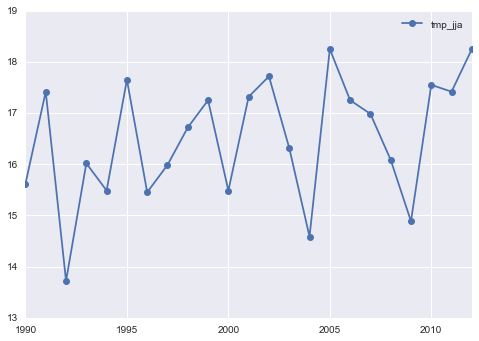

In [8]:
# Select series
stn_id = 23455
var = 'tmp_jja'
df2 = df.query("(station_id==@stn_id) & (var==@var)")

df2 = df2[range(1990, 2013)].T
df2.columns = [var]
df2.plot(ls='-', marker='o')

This all seems OK.